# Laboratory work 6: differential equations

---

## Work objective:

Solve a system of ordinary differential equations (ODEs) by:

1) Runge-Kutta methods;
2) Adams methods;
3) Backward differentiation formula.

The example to which these methods were applied is well-known Van der Pol equation

\begin{equation*}
    \ddot{x} + \mu(x^2 - 1)\dot{x} + x = 0
\end{equation*}

We have to transform the equation of the 2nd order into a system of equations of the 1st order to
be able to apply aforementioned methods. It may be done the following way:

\begin{cases}
    \dot{z} = y \\
    \dot{y} = \mu(1 - z^2)y + z
\end{cases}

Another thing worth mentioning is that numerical methods can solve Cauchy problem but not find the
general solution. It means we should also provide initial values of functions $z(t)$ and $y(t)$:

\begin{cases}
    z(0) = 2 \\
    y(0) = 0\
\end{cases}

Let's also say that we won't try to find the solution for $t \in [0; +\infty)$, but only for
$t \in [0; 100]$.

## Imports

In [48]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

## Runge-Kutta methods

In [49]:
"""
dx/dt = f(t, x), t in [t_1; t_2], x in R^n
x(t_1) = x_0
-------
N:       number of intervals [t_1; t_2] is divided into
A, B, C: parts of Butcher tableau;
"""
def Explicit_Runge_Kutta(f, x_0, t_1, t_2, N, A, B, C, n_steps):

    order = len(B)
    if order != len(C):
        raise RuntimeError("The size of B-part of Butcher tableau mismatches the size of C-part")
    elif C[0] != 0:
        raise RuntimeError("The first element of C shall equal to 0")
    elif n_steps > N:
        raise RuntimeError("The number of steps has to be not greater than the number of intervals")

    t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
    dt = (t_2 - t_1) / N

    dim = len(x_0)
    x = np.empty(shape=(n_steps + 1, dim))
    x[0] = x_0

    k = np.empty(shape=(order, dim))

    for n in range(n_steps):
        for i in range(order):
            k[i] = f(t[n] + dt * C[i], x[n] + dt * sum(A[i - 1][j] * k[j] for j in range(i)))
        x[n + 1] = x[n] + sum(B[j] * k[j] for j in range(order)) * dt

    if n_steps < N:
        t = np.resize(t, n_steps)

    return t, x

## Adams methods

We will implement method of the 4th order which is of form:

\begin{equation*}
    x_{n + 1} = x_n + \frac{\tau}{24}(55f_n - 59f_{n - 1} + 37f_{n - 2} - 9f_{n - 3}),\ n \in \{3, ..., N\}
\end{equation*}

As far as the method can't be used to find $x_1$, $x_2$, $x_3$ we will run Runge-Kutta method at first
to calculate these values.

In [50]:
def Adams_4(F, x_0, t_1, t_2, N):

    order = 4
    if len(x_0) != order:
        raise RuntimeError("The number of initial values for a multistep method of the 4th order has to be 4")

    t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
    dt = (t_2 - t_1) / N

    dim = len(x_0[0])
    x = np.empty(shape=(N + 1, dim))
    f = np.empty(shape=(order, dim))
    for i in range(order):
        x[i] = x_0[i]
        f[i] = F(t[i], x_0[i])

    for n in range(order - 1, N - 1):
        x[n + 1] = x[n] + dt * (55 * f[3] - 59 * f[2] + 37 * f[1] - 9 * f[0]) / 24
        f = np.roll(f, -1)
        f[3] = F(t[n + 1], x[n + 1])

    x[N] = x[N - 1] + dt * (55 * f[3] - 59 * f[2] + 37 * f[1] - 9 * f[0]) / 24

    return t, x

## Backwards differentiation formula (BDF)

We will implement method of the 4th order which is of form:

\begin{equation*}
    x_{n + 4} = \frac{1}{25}(48x_{n + 3} - 36x_{n + 2} + 16x_{n + 1} - 3x_n + 12\tau f(t_{n + 4}, x_{n + 4})),\
    n \in \{0, ..., N - 4\}
\end{equation*}

As far as the method can't be used to find $x_1$, $x_2$, $x_3$ we will run Runge-Kutta method at first
to calculate these values.

In [51]:
def BDF_4(F, x_0, t_1, t_2, N):

    order = 4
    if len(x_0) != order:
        raise RuntimeError("The number of initial values for a multistep method of the 4th order has to be 4")

    t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
    dt = (t_2 - t_1) / N

    dim = len(x_0[0])
    x = np.empty(shape=(N + 1, dim))
    x[:4] = x_0
    for n in range(N - 3):
        func = lambda x_4: x_4 - (48*x[n + 3] - 36*x[n + 2] + 16*x[n + 1] - 3*x[n] + 12*dt*F(t[n + 4], x_4)) / 25
        # consider x[n + 3] a good choice as a starting estimate because of x's continuity
        x[n + 4] = fsolve(func, x[n + 3])

    return t, x

## Results

We will use the following Butcher tableau for Runge-Kutta method of the 4th order:

| 0 |   |   |   |   |
|:-:|:-:|:-:|:-:|:-:|
|1/2|1/2|   |   |   |
|1/2| 0 |1/2|   |   |
| 1 | 0 | 0 | 1 |   |
|   |1/6|2/6|2/6|1/6|

In [52]:
N = 20000
x_0 = [2, 0]
t_1 = 0
t_2 = 100

a = [[0.5],
     [0.0, 0.5],
     [0.0, 0.0, 1.0]]
b = np.array([1.0/6.0, 2.0/6.0, 2.0/6.0, 1.0/6.0])
c = np.array([0.0, 0.5, 0.5, 1.0])

MU = [0.01, 0.02, 0.5, 1, 2, 5, 10, 20, 50, 100]

def Run_Adams_4(F, x_0, t_1, t_2, N):

    _, x = Explicit_Runge_Kutta(F, x_0, t_1, t_2, N, a, b, c, n_steps=3)

    return Adams_4(F, [x_0, x[0], x[1], x[2]], t_1, t_2, N)

def Run_BDF_4(F, x_0, t_1, t_2, N):

    _, x = Explicit_Runge_Kutta(F, x_0, t_1, t_2, N, a, b, c, n_steps=3)

    return BDF_4(F, [x_0, x[0], x[1], x[2]], t_1, t_2, N)

def compute_Van_der_Pol(method, N, mu):

    F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])
    t, x = Explicit_Runge_Kutta(F, x_0=[2, 0], t_1=0, t_2=100, N=N, A=a, B=b, C=c, n_steps=N)
    x = np.delete(x, 1, 1)

def draw(t, x, mu):

    plt.figure(figsize = (21, 9), dpi = 100)
    plt.title("Solution of Van der Pol equation", fontsize = 30)

    plt.xlabel("t", fontsize = 24)
    plt.xticks(fontsize =  20, ha = "center", va = "top")

    plt.ylabel("x(t)", fontsize = 24)
    plt.yticks(fontsize = 20, rotation = 30, ha = "right", va = "top")

    plt.scatter(t, x, s = 5, color = "black")
    plt.plot(t, x, linewidth = 1, color = "black", label = f"$\\mu = {mu}$")

    plt.legend(loc = "upper right", fontsize = 16)

    plt.grid (color = "black", linewidth = 0.45, linestyle = "dotted")
    plt.minorticks_on()
    plt.grid (which = "minor", color = "grey", linewidth = 0.25, linestyle = "dashed")

    plt.show()

### Runge-Kutta results

In [53]:
for mu in MU:
    F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])
    t, x = Explicit_Runge_Kutta(F, x_0, t_1, t_2, N, a, b, c, N)
    x = np.delete(x, 1, 1)
    draw(t, x, mu)

### Adams method results

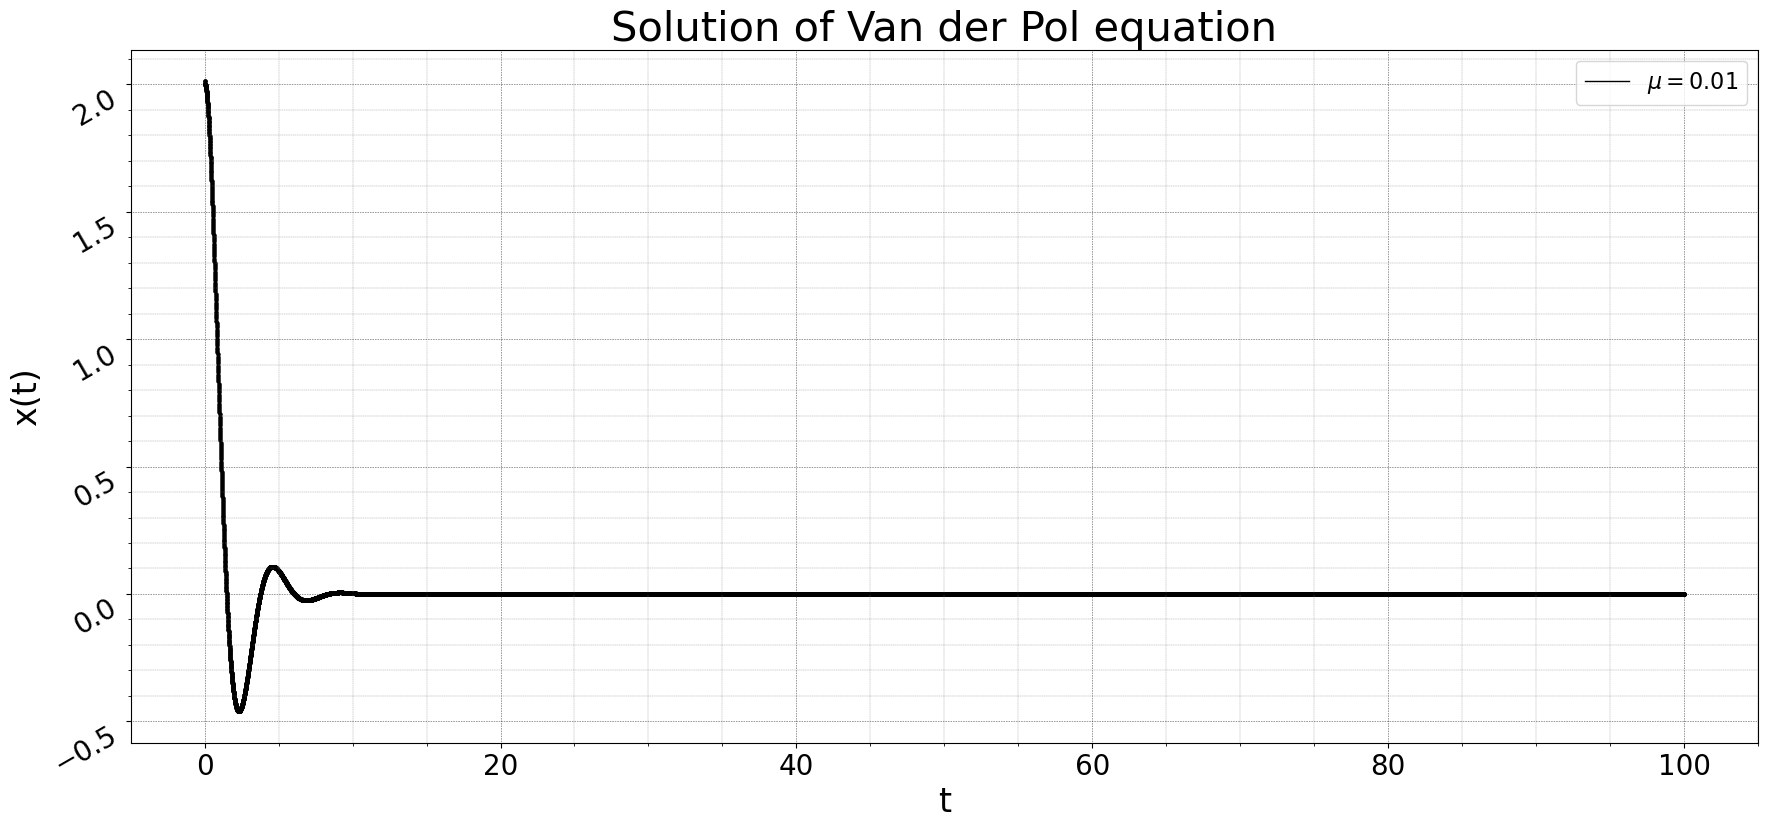

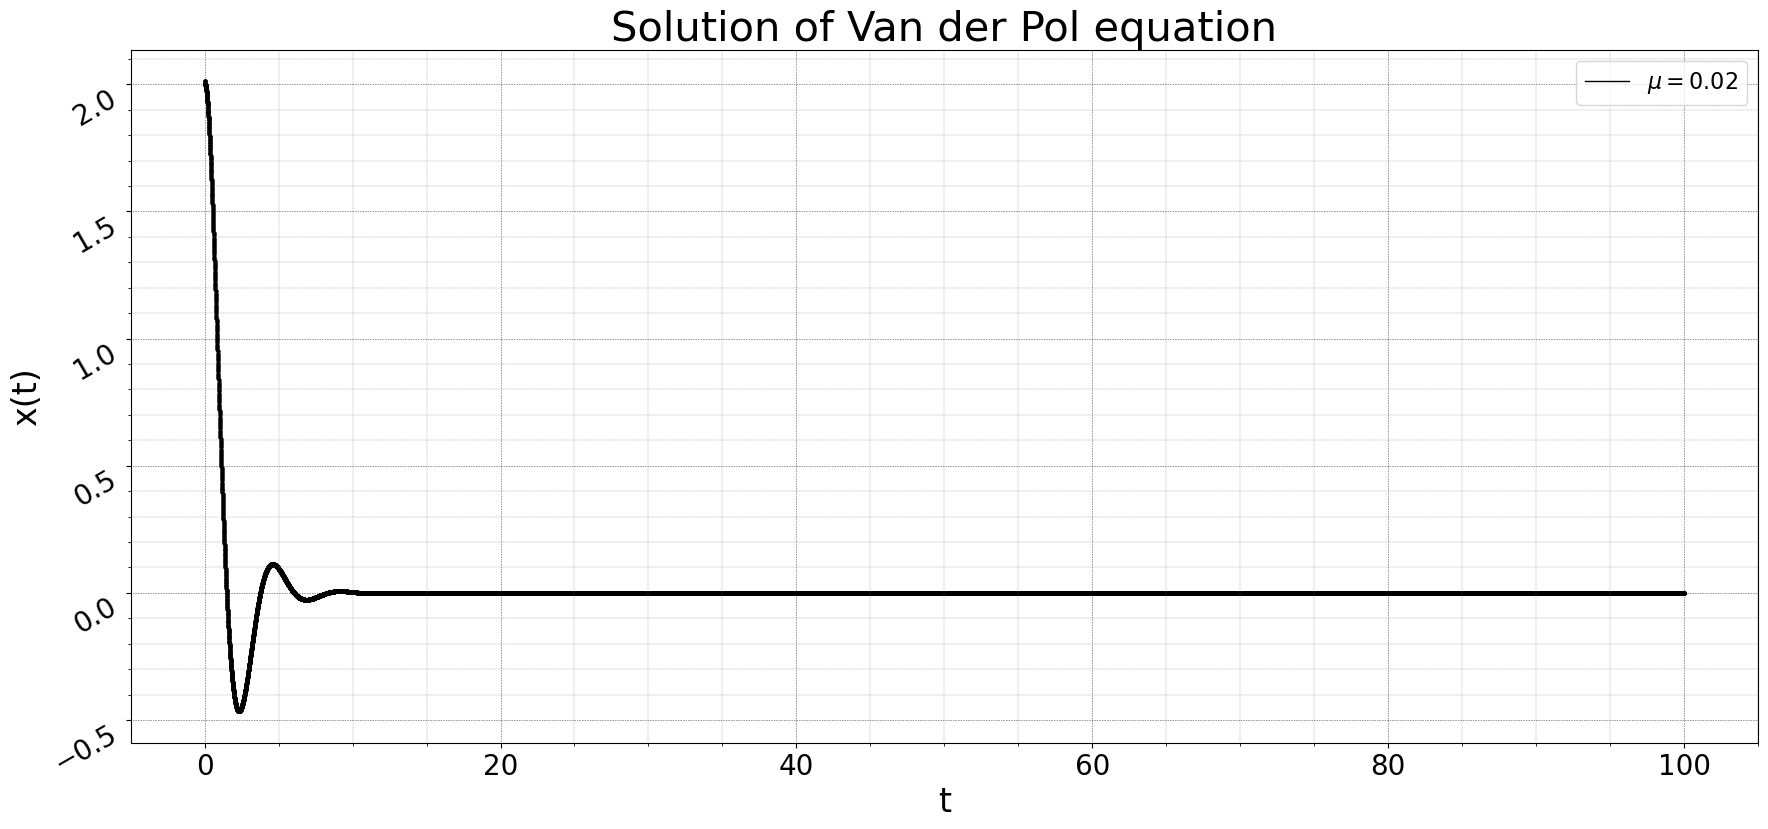

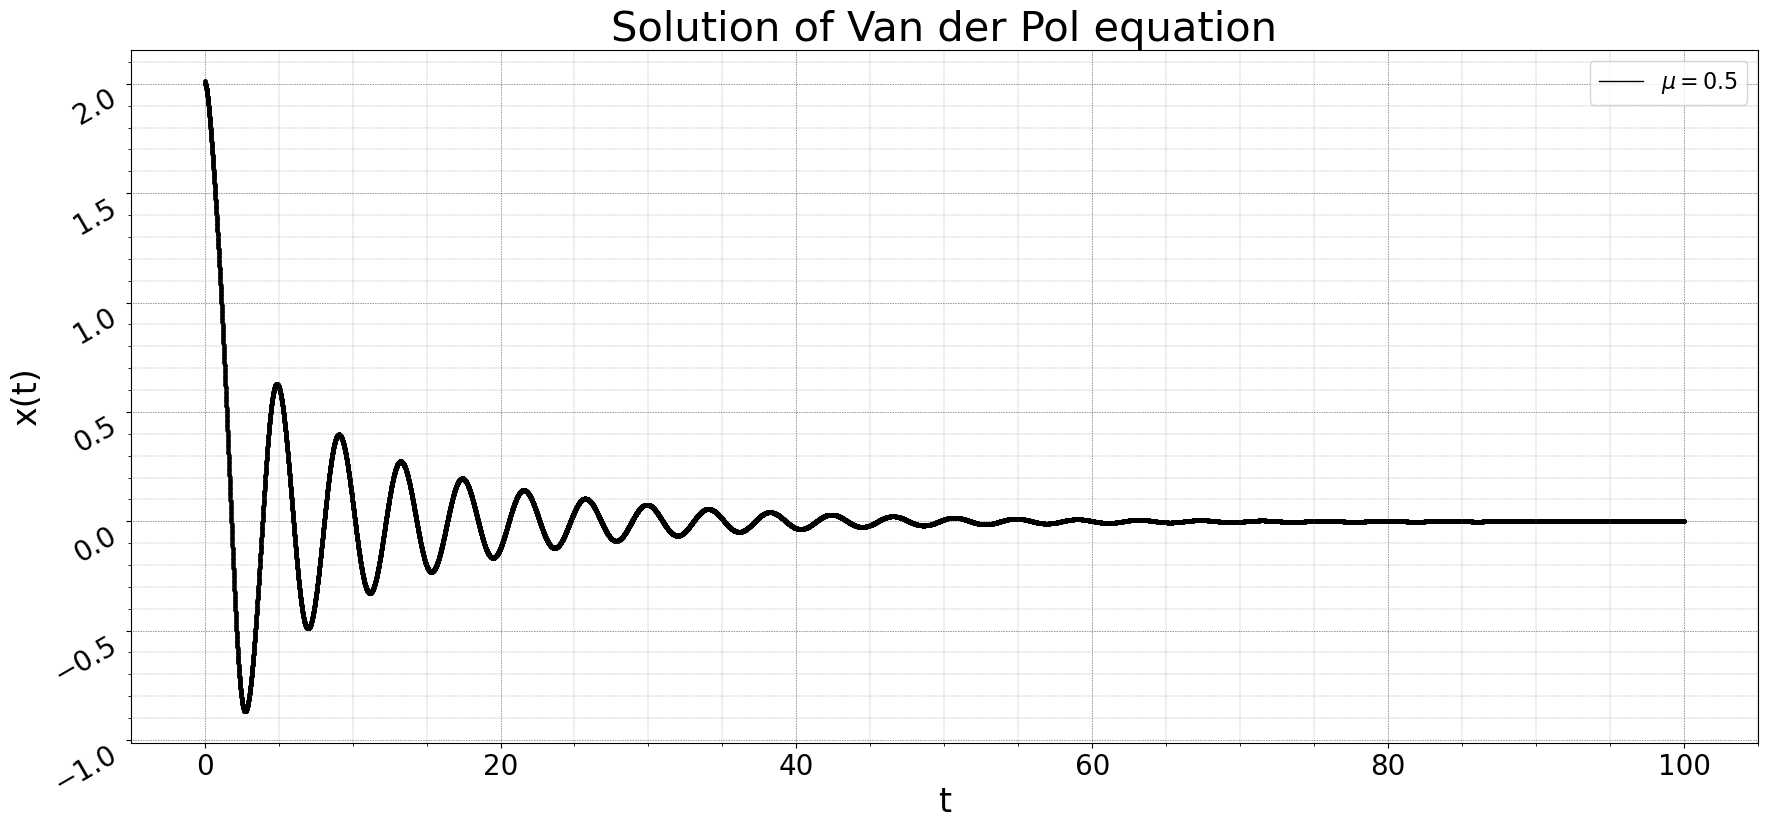

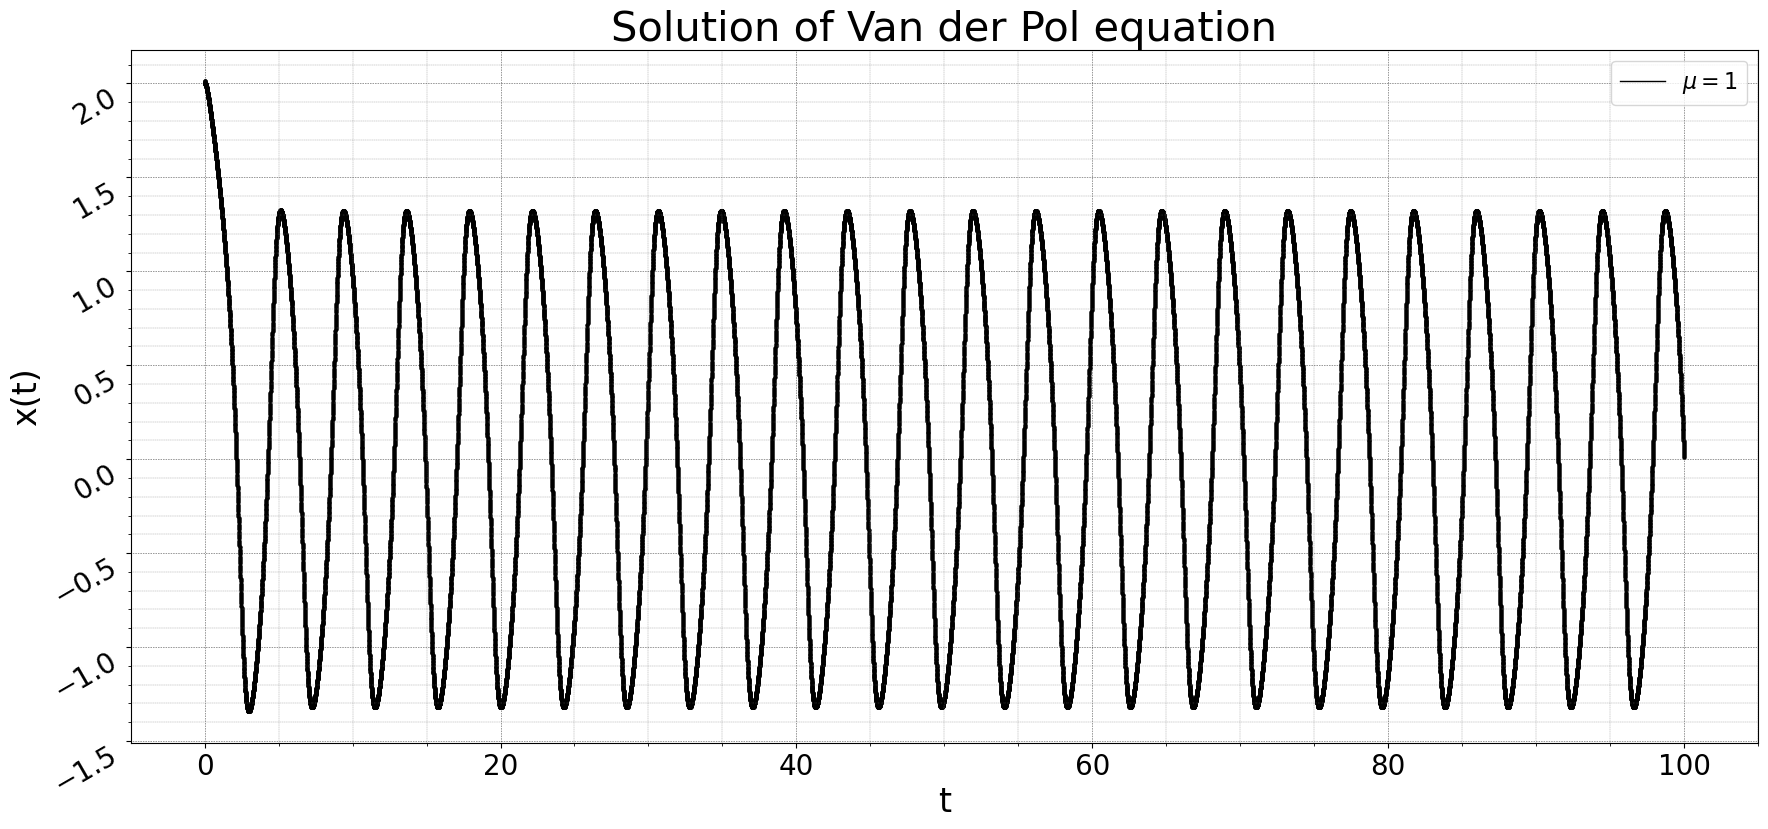

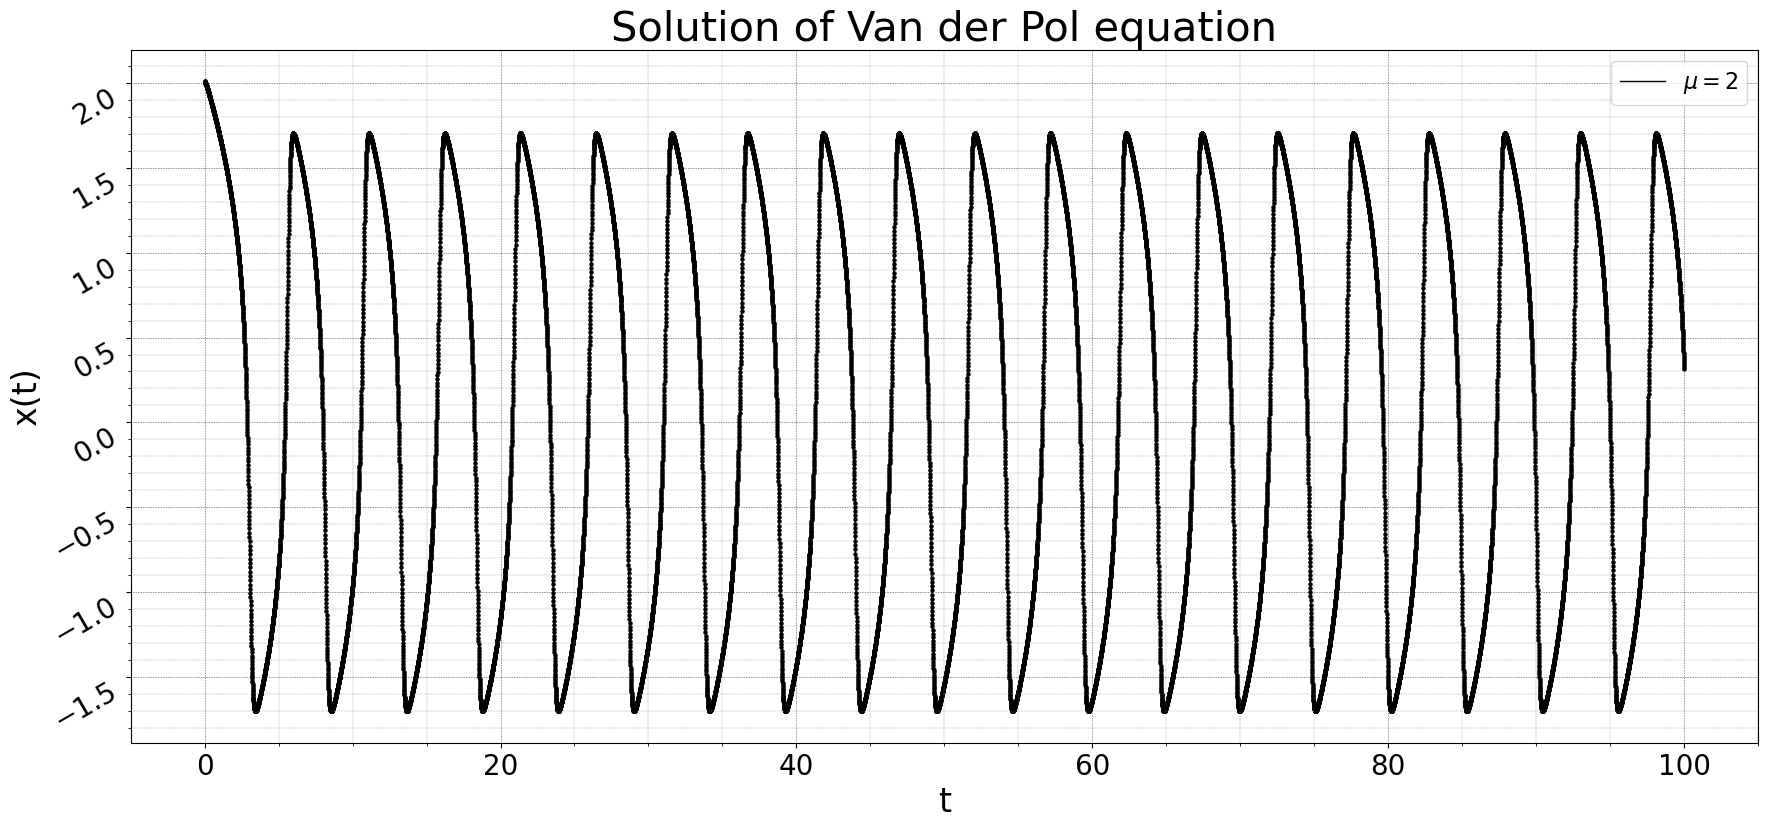

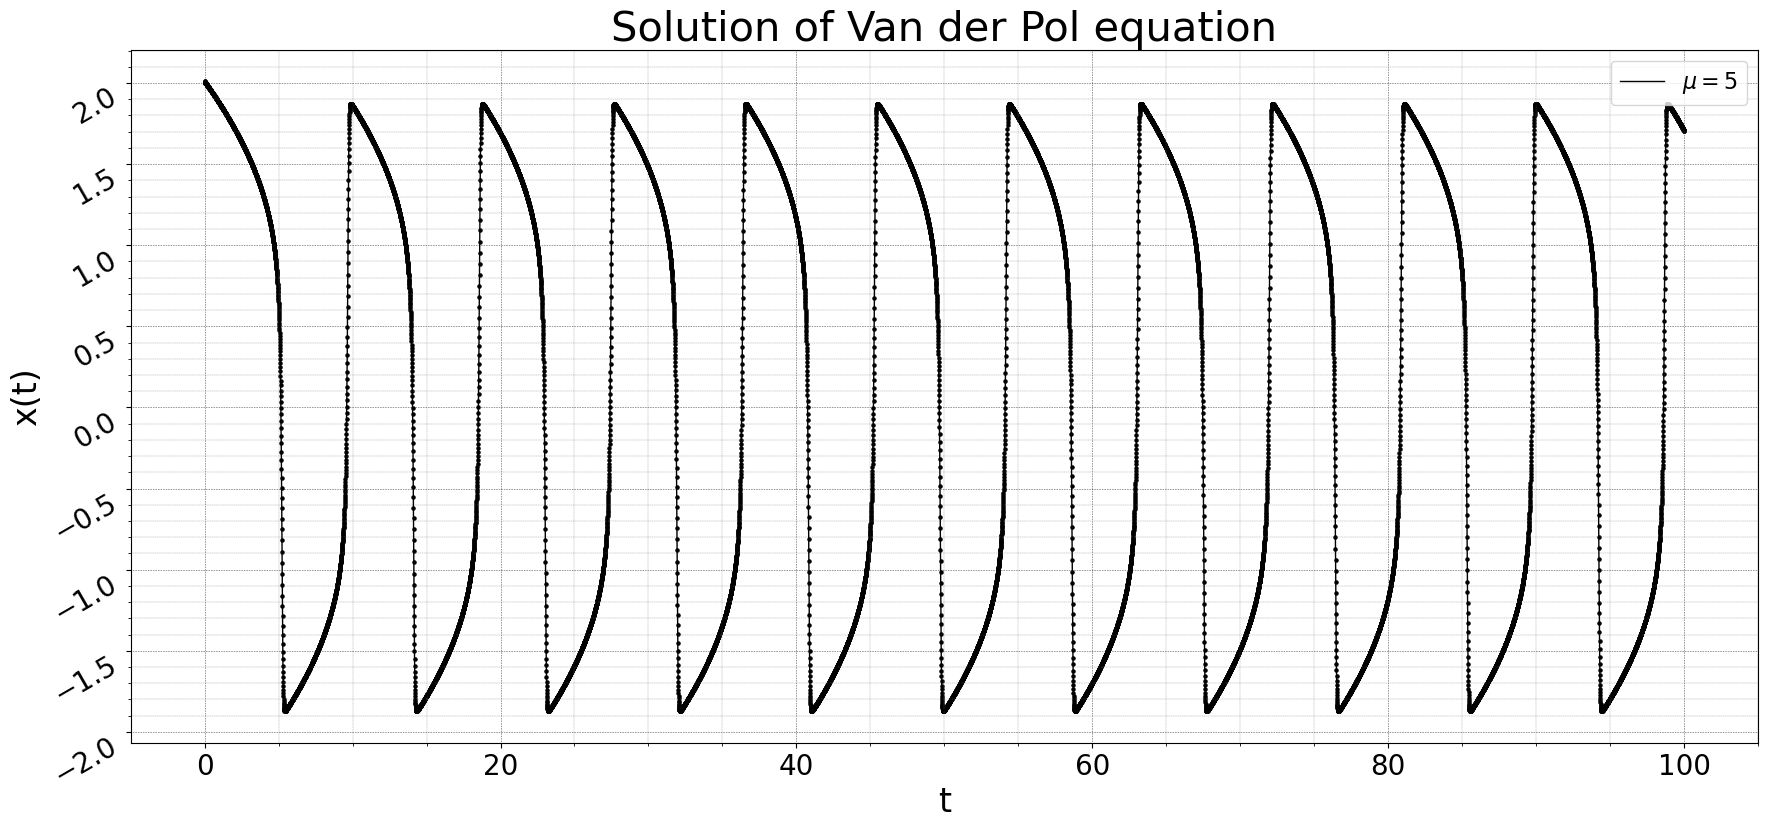

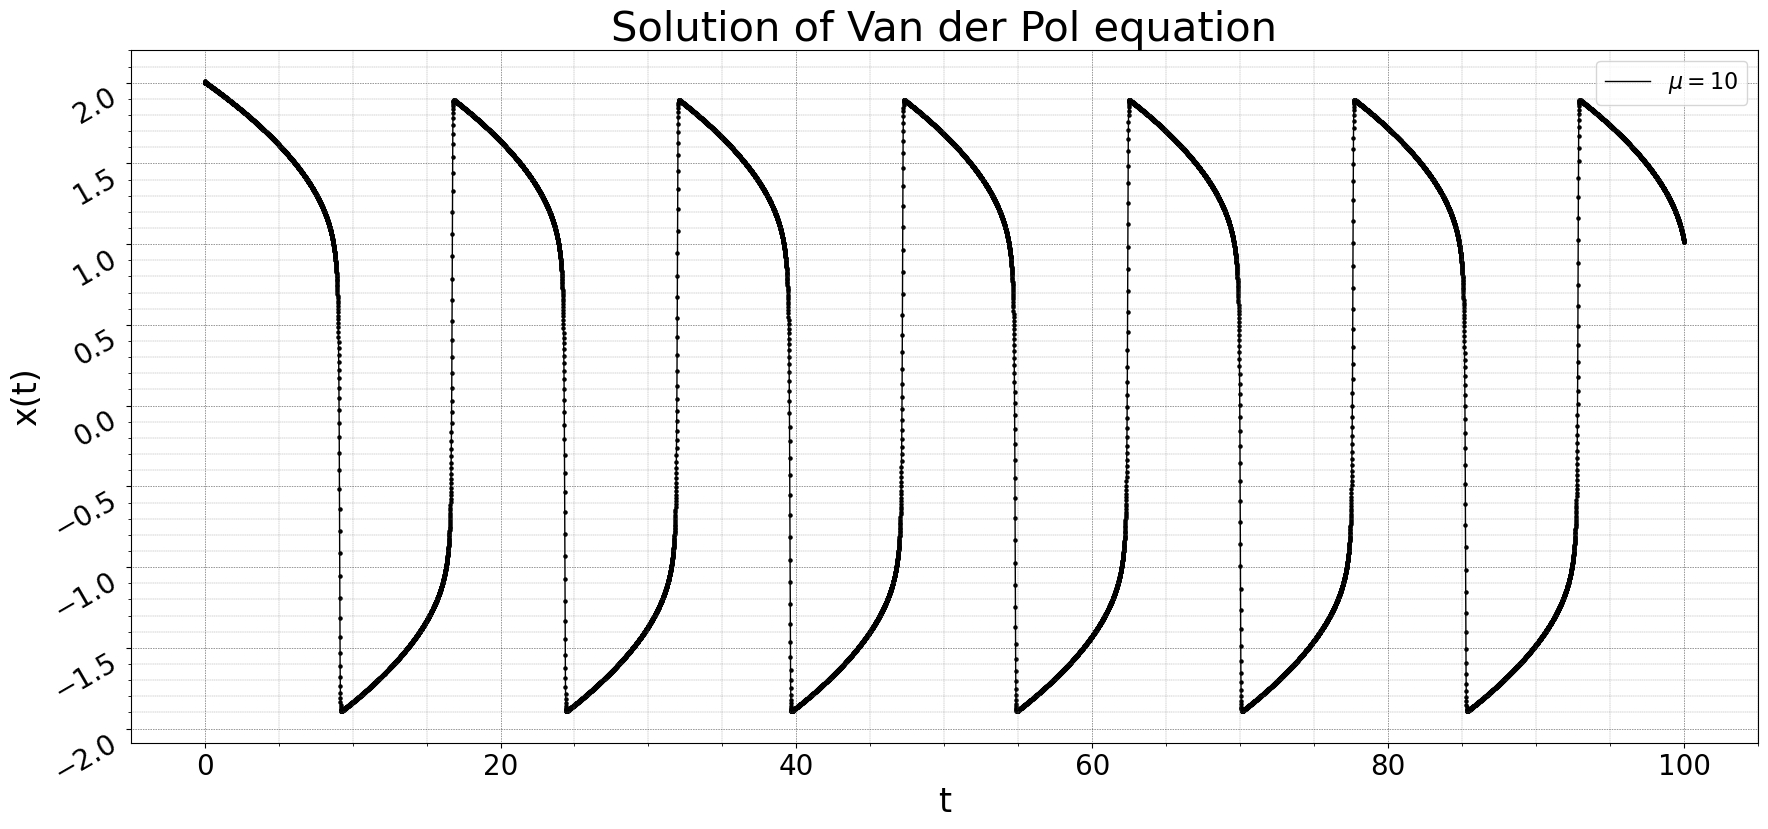

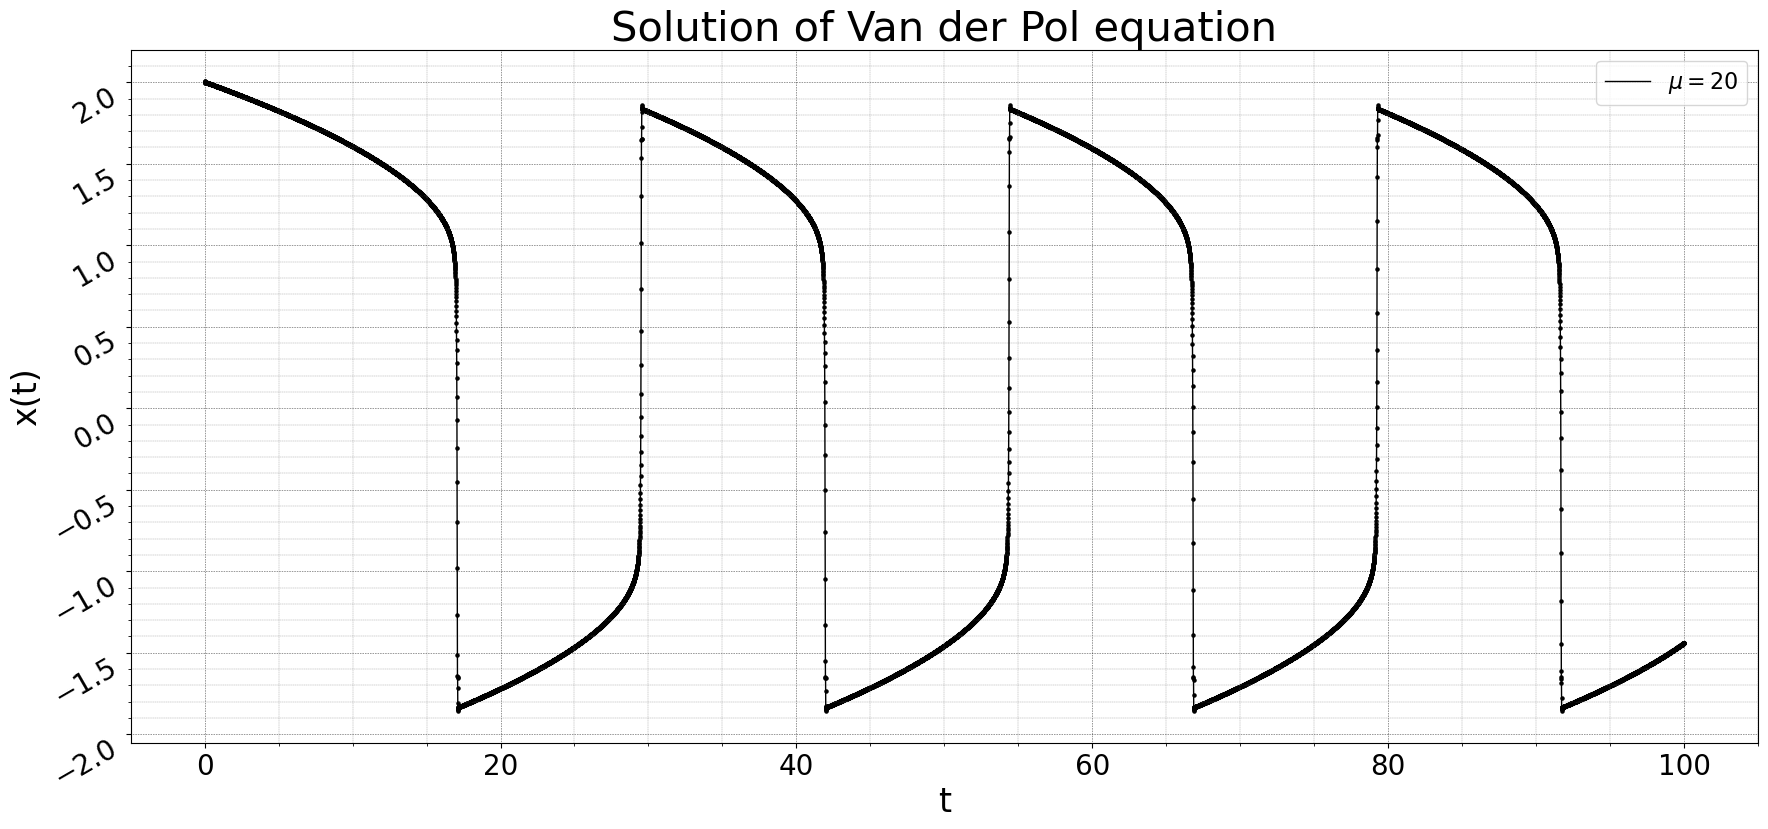

/tmp/ipykernel_83210/2058578161.py:2: RuntimeWarning: overflow encountered in double_scalars
  F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])
/tmp/ipykernel_83210/2653974170.py:18: RuntimeWarning: invalid value encountered in add
  x[n + 1] = x[n] + dt * (55 * f[3] - 59 * f[2] + 37 * f[1] - 9 * f[0]) / 24


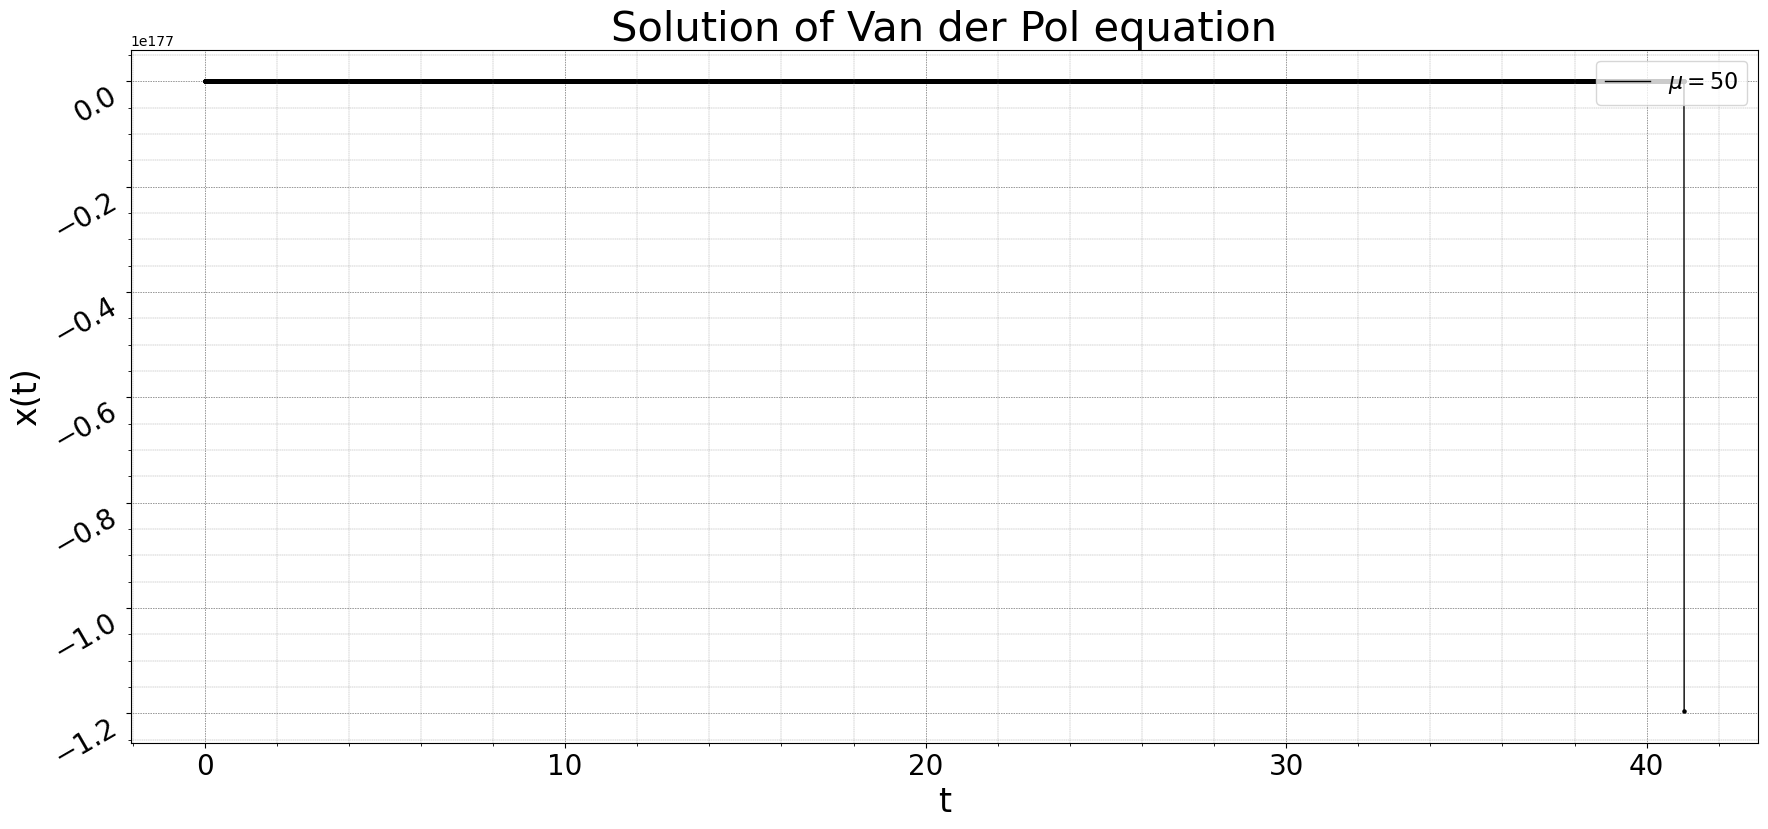

/tmp/ipykernel_83210/2058578161.py:2: RuntimeWarning: overflow encountered in double_scalars
  F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])
/tmp/ipykernel_83210/2653974170.py:18: RuntimeWarning: invalid value encountered in add
  x[n + 1] = x[n] + dt * (55 * f[3] - 59 * f[2] + 37 * f[1] - 9 * f[0]) / 24


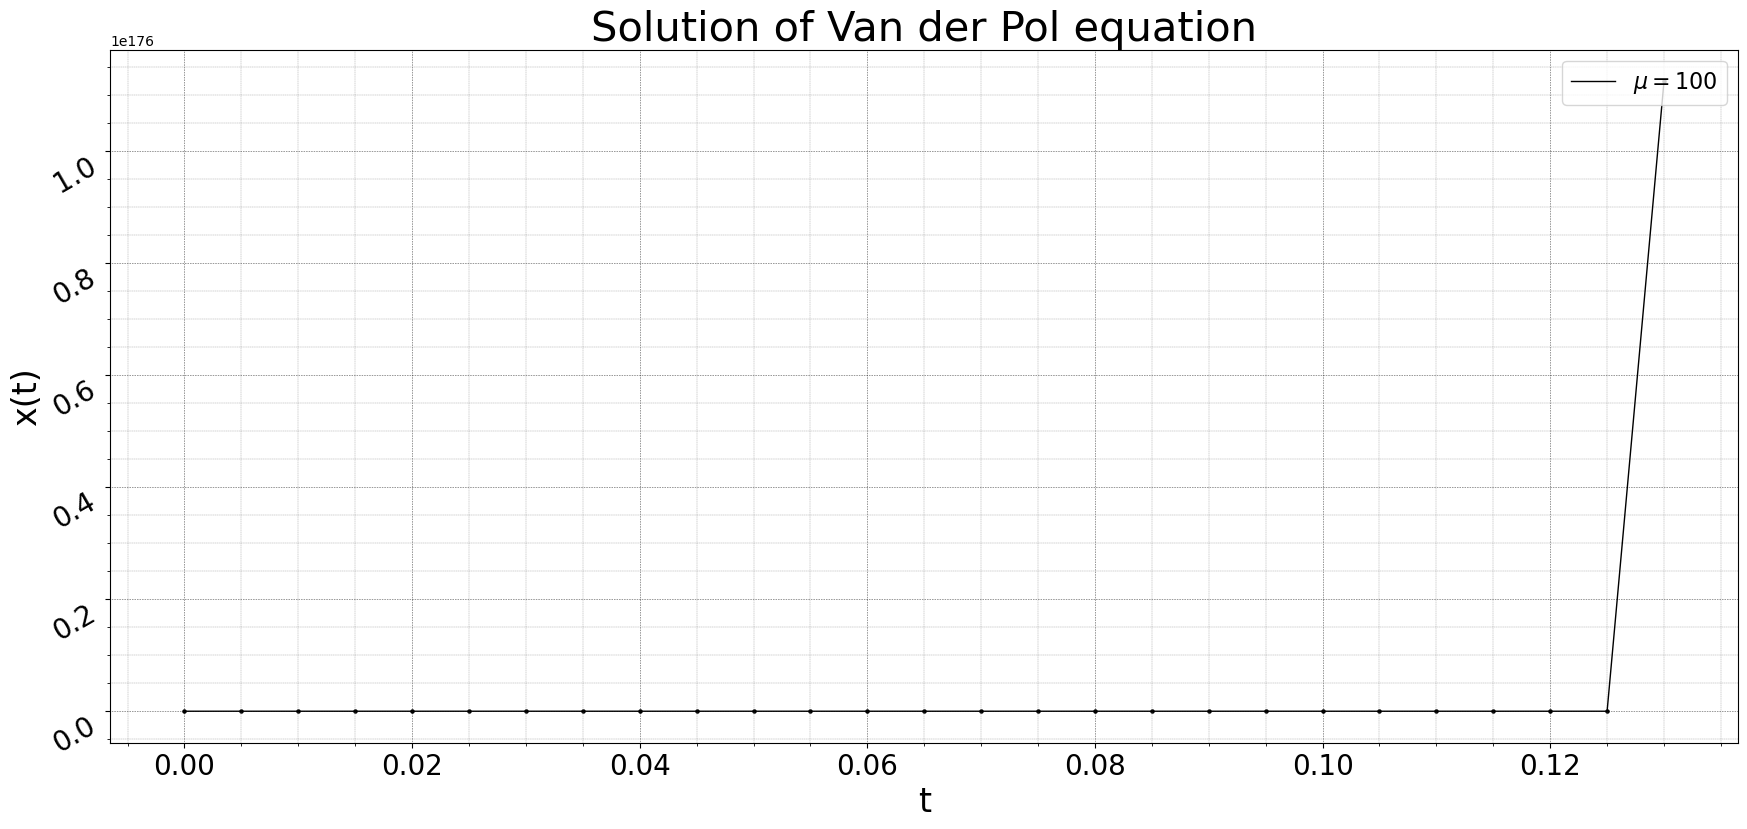

In [54]:
for mu in MU:
    F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])
    t, x = Run_Adams_4(F, x_0, t_1, t_2, N)
    x = np.delete(x, 1, 1)
    draw(t, x, mu)

### Backwards differentiation formula results

In [55]:
for mu in MU:
    F = lambda t, x: np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]])
    t, x = Run_BDF_4(F, x_0, t_1, t_2, N)
    x = np.delete(x, 1, 1)
    draw(t, x, mu)